Look into cases we get very wrong, ie. severity 1 but predicted severity 4.

We'll look at the predictions from our best model - third place sentinel and land cover features, predicting log density, with folds and a higher number of boosted rounds.

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
from cloudpathlib import AnyPath
import geopandas as gpd
from loguru import logger
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Point

from cyano.data.utils import add_unique_identifier
from cyano.settings import REPO_ROOT

## Load data

In [3]:
best_exp_dir = AnyPath(
    "s3://drivendata-competition-nasa-cyanobacteria/experiments/results/third_sentinel_with_folds"
)
cache_dir = REPO_ROOT.parent / "experiments/cache"

In [4]:
# load all metadata for reference
meta = pd.read_csv(
    AnyPath(
        "s3://drivendata-competition-nasa-cyanobacteria/data/final/combined_final_release.csv"
    )
)
meta.head(3)

,uid,data_provider,region,latitude,longitude,date,density_cells_per_ml,severity,distance_to_water_m
0,aabm,Indiana State Department of Health,midwest,39.080319,-86.430867,2018-05-14,585.0,1,0.0
1,aabn,California Environmental Data Exchange Network,west,36.559700,-121.510000,2016-08-31,5867500.0,4,3512.0
2,aacd,N.C. Division of Water Resources N.C. Departme...,south,35.875083,-78.878434,2020-11-19,290.0,1,514.0


In [5]:
# load our satellite metadata
sat_meta = pd.read_csv(cache_dir / "satellite_metadata_test.csv")
sat_meta.shape

(22115, 36)

In [6]:
sat_meta.head(2)

,item_id,datetime,platform,min_long,max_long,min_lat,max_lat,bbox_from_geometry,eo:cloud_cover,s2:water_percentage,...,B07_href,B08_href,B09_href,B11_href,B12_href,B8A_href,SCL_href,WVP_href,days_before_sample,sample_id
0,S2A_MSIL2A_20160823T184922_R113_T10SFF_2021021...,2016-08-23,Sentinel-2A,-121.88976,-120.641532,36.034203,37.041254,False,3.177571,4.398244,...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,8,4a89ead93e2caa84da636236bb361e12
1,S2A_MSIL2A_20190815T165901_R069_T15SUD_2020100...,2019-08-15,Sentinel-2A,-95.32843,-94.038120,38.738210,39.745494,False,99.677835,0.003592,...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,https://sentinel2l2a01.blob.core.windows.net/s...,11,494fb91d1fb8697e73b90e5d0c9420ed


In [7]:
# load best predictions
preds = pd.read_csv(best_exp_dir / "preds.csv", index_col=0)
preds.head()

,date,latitude,longitude,log_density,severity
sample_id,,,,,
4a89ead93e2caa84da636236bb361e12,2016-08-31,36.559700,-121.51000,15.472787,4.0
a7e2d76f204ac347ae5529557eb7f665,2014-11-01,33.042600,-117.07600,NaN,NaN
6afcb31acb56fc25af76983df6a60d0a,2015-08-26,40.703968,-80.29305,NaN,NaN
494fb91d1fb8697e73b90e5d0c9420ed,2019-08-26,38.972500,-94.67293,10.436847,2.0
21e1f934b140745d1cde757090aa07fa,2018-01-08,34.279000,-118.90500,13.364631,3.0


In [8]:
# load actual
true = pd.read_csv(
    AnyPath(
        "s3://drivendata-competition-nasa-cyanobacteria/experiments/splits/competition/test.csv"
    )
)
true = add_unique_identifier(true)
true.head(2)

,uid,data_provider,region,latitude,longitude,date,density_cells_per_ml,severity,distance_to_water_m,log_density
sample_id,,,,,,,,,,
4a89ead93e2caa84da636236bb361e12,aabn,California Environmental Data Exchange Network,west,36.5597,-121.510,2016-08-31,5867500.0,4,3512.0,15.584939
a7e2d76f204ac347ae5529557eb7f665,aair,California Environmental Data Exchange Network,west,33.0426,-117.076,2014-11-01,2769000.0,4,195.0,14.833997


In [9]:
true["pred_severity"] = preds.loc[true.index].severity
true["pred_log_density"] = preds.loc[true.index].log_density

In [10]:
# check samples with actual severity 1 but predicted severity 4
check = true[(true.severity == 1) & (true.pred_severity == 4)]
check.shape

(36, 12)

## Sample metadata

What region are these from? What providers? 

In [11]:
# almost all are in the south
check.region.value_counts()

region
south      29
midwest     5
west        2
Name: count, dtype: int64

In [12]:
# almost all are north carolina
# could these be routine sites with inaccurate gps data?
check.data_provider.value_counts()

data_provider
N.C. Division of Water Resources N.C. Department of Environmental Quality    29
US Army Corps of Engineers                                                    3
California Environmental Data Exchange Network                                2
EPA National Aquatic Research Survey                                          1
Bureau of Water Kansas Department of Health and Environment                   1
Name: count, dtype: int64

In [13]:
# pull in original NC data
logger.info("Loading raw NC data")
nc_raw = pd.read_excel(
    AnyPath(
        "s3://drivendata-competition-nasa-cyanobacteria/data/raw/nc/New Use This NCDWR phyto 2013-2021 All Data.xlsx"
    ),
    sheet_name="Cyanobacteria Density",
)
logger.info(f"Loaded {nc_raw.shape[0]:,} rows of raw NC data")

nc_raw = nc_raw.rename(columns={"Lat": "latitude", "Long": "longitude"})
nc_raw["date"] = pd.to_datetime(nc_raw.Date)
nc_raw.head(2)

2023-08-29 12:07:35.404 | INFO     | __main__:<module>:2 - Loading raw NC data
2023-08-29 12:07:43.005 | INFO     | __main__:<module>:9 - Loaded 14,339 rows of raw NC data


,Waterbody,StationDesc,SiteCode,Date,Smplid,AlgalGroup,Genus,Species,Cell Density,Unit Density,Biovolume,latitude,longitude,date
0,Laurel Lea Lake,NaN,ES9954,2013-10-24,9954-2013,Cyanobacteria,Microcystis,aeruginosa,27131.0,209.0,814.0,34.28071,-77.76675,2013-10-24
1,Laurel Lea Lake,NaN,ES9954,2013-10-24,9954-2013,Cyanobacteria,Aphanocapsa,incerta,129396.0,626.0,65.0,34.28071,-77.76675,2013-10-24


In [14]:
# Get the subset of NC data that has low severity, high predicted severity
raw_subset = check[["latitude", "longitude"]].merge(
    nc_raw, how="inner", on=["latitude", "longitude"]
)
logger.info(
    f"{raw_subset.shape[0]:,} rows of raw NC are from locations with low severity, high predicted severity"
)

2023-08-29 12:07:43.086 | INFO     | __main__:<module>:5 - 1,629 rows of raw NC are from locations with low severity, high predicted severity


In [15]:
# What waterbodies is this subset from?
raw_subset.Waterbody.value_counts(dropna=False)

Waterbody
Cape Fear River    984
Pamlico River      630
Lake Stewart        13
Lake Monroe          2
Name: count, dtype: int64

In [16]:
raw_subset.groupby(["Waterbody", raw_subset.date.dt.year]).size().sort_index()

Waterbody        date
Cape Fear River  2019    400
                 2020    584
Lake Monroe      2021      2
Lake Stewart     2021     13
Pamlico River    2017     78
                 2018     84
                 2019    192
                 2020     18
                 2021    258
dtype: int64

In an email from Elizabeth Fensin in NC:
> I’m also surprised I sent data from the Cape Fear River 2020-2021 study since it was unusual.  We usually assign one taxonomist to particular waterbodies to ensure uniform results.  In the Cape Fear study, one taxonomist did the 2020 and another did the 2021 samples.  This created confusing results and some samples were recounted.

She also noted that routinely monitored sites were more likely to have inaccurate GPS data. Pamlico is one of their ambient sites.

One option is to drop both the Cape Fear and Pamlico River data, since it seems suspect.

In [17]:
# how much of our final data is from cape fear river?
cape_fear_coords = nc_raw[nc_raw.Waterbody == "Cape Fear River"][
    ["latitude", "longitude"]
].drop_duplicates()
logger.info(f"Cape fear has {cape_fear_coords.shape[0]} locations")

cape_fear_final = cape_fear_coords.merge(
    meta, on=["latitude", "longitude"], how="inner"
)
assert (
    cape_fear_final.data_provider
    == "N.C. Division of Water Resources N.C. Department of Environmental Quality"
).all()
logger.info(f"{cape_fear_final.shape[0]} final data points are from cape fear")

2023-08-29 12:07:43.230 | INFO     | __main__:<module>:5 - Cape fear has 4 locations
2023-08-29 12:07:43.244 | INFO     | __main__:<module>:14 - 82 final data points are from cape fear


In [18]:
# would we also want to drop pamlico? how much data is from pamlico?
pamlico_coords = nc_raw[nc_raw.Waterbody == "Pamlico River"][
    ["latitude", "longitude"]
].drop_duplicates()
logger.info(f"Pamlico river fear has {pamlico_coords.shape[0]} locations")

pamlico_final = pamlico_coords.merge(meta, on=["latitude", "longitude"], how="inner")
assert (
    pamlico_final.data_provider
    == "N.C. Division of Water Resources N.C. Department of Environmental Quality"
).all()
logger.info(f"{pamlico_final.shape[0]} final data points are from pamlico river")

2023-08-29 12:07:43.300 | INFO     | __main__:<module>:5 - Pamlico river fear has 621 locations
2023-08-29 12:07:43.314 | INFO     | __main__:<module>:12 - 683 final data points are from pamlico river


In [19]:
states_shapefile = gpd.GeoDataFrame.from_file(
    "s3://drivendata-competition-nasa-cyanobacteria/data/raw/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
)

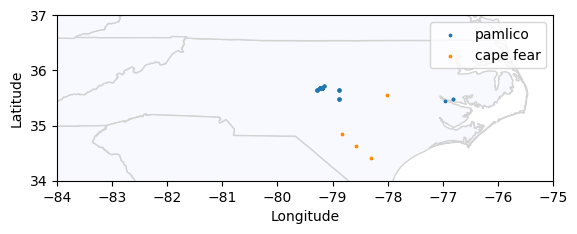

In [20]:
ax = states_shapefile.loc[:, "geometry"].plot(color="ghostwhite", edgecolor="lightgray")

geo = [Point(xy) for xy in zip(pamlico_coords.longitude, pamlico_coords.latitude)]
gdf = gpd.GeoDataFrame(pamlico_coords, geometry=geo)
gdf.plot(ax=ax, markersize=3, label="pamlico")

geo = [Point(xy) for xy in zip(cape_fear_coords.longitude, cape_fear_coords.latitude)]
gdf = gpd.GeoDataFrame(cape_fear_coords, geometry=geo)
gdf.plot(ax=ax, markersize=3, color="darkorange", label="cape fear")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.set_xlim([-84, -75])
ax.set_ylim([34, 37])
plt.legend()

The pamlico river points are generally very far from the pamlico river. Besides the few farther east, the rest of the points are all much farther south than the tar or the neuse river. They are a little west of the Jordan Lake, so not in either the Tar-Pamlico or Neuse water basin. The Neuse river is a separate waterbody in the data, as is Jordan Lake.

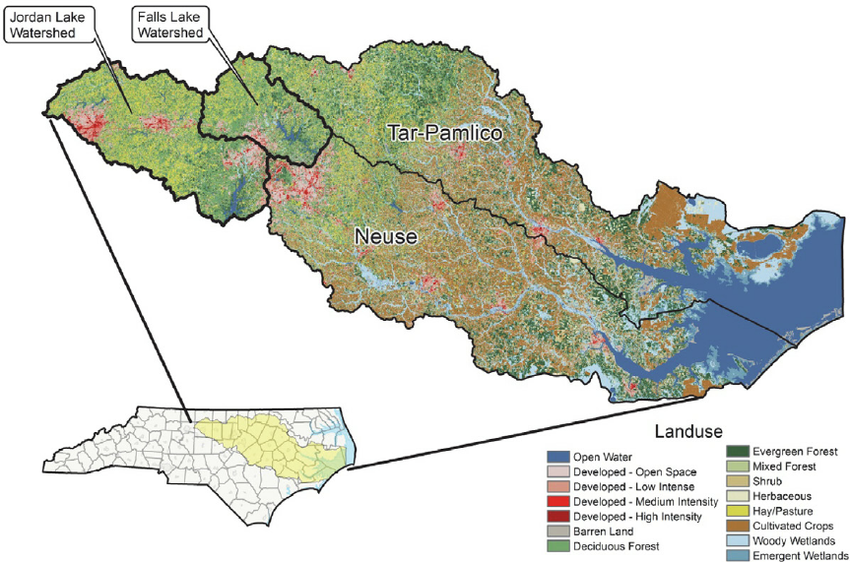

The cape fear points are generally consistent with where the cape fear river is

In [21]:
pd.concat(
    [
        cape_fear_final.distance_to_water_m.describe().rename("cape_fear"),
        pamlico_final.distance_to_water_m.describe().rename("pamlico"),
        meta.distance_to_water_m.describe().rename("all_data"),
    ],
    axis=1,
)

,cape_fear,pamlico,all_data
count,82.000000,683.000000,23569.000000
mean,415.341463,735.096633,436.444525
std,318.091035,342.847096,600.447428
min,46.000000,0.000000,0.000000
25%,199.000000,564.000000,0.000000
50%,339.000000,759.000000,246.000000
75%,835.000000,964.000000,664.000000
max,835.000000,1364.000000,6468.000000


**Takeaway**

The odd behavior of the model on these cases could be related to inaccurate lat / longs or inaccurate ground truth measurements. 

- The cape fear data in particular was flagged by our NC contact as being potentially confusing
- Ambient sites like pamlico were flagged for potentially inaccurate GPS locations. The points in the NC dataset that say they are for the pamlico river are generally not anywhere near the pamlico river
- We can also see that both cape fear and pamlico data points tend to be farther from water than the rest of the data, with pamlico being worse
- There are 82 final data points from cape fear, and 683 from pamlico

**I recommend removing both pamlico river and cape fear river data from our train / test sets**

## Satellite metadata

Based on the satellite metadata, are the images for the subset of samples with low severity but high predicted severity different from other images?

In [22]:
# get one row per image,
# including indication of whether that image is used for our subset to check
sat_meta["low_actual_high_pred"] = sat_meta.sample_id.isin(check.index).astype(str)

sat_meta = sat_meta.drop(columns=["sample_id"]).groupby("item_id").max()
sat_meta["low_actual_high_pred"].value_counts()

low_actual_high_pred
False    8580
True      163
Name: count, dtype: int64

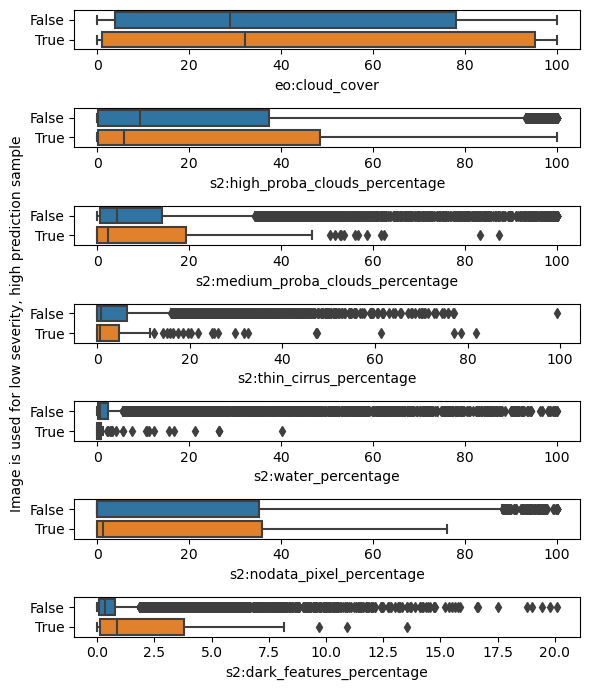

In [23]:
show_cols = [
    "eo:cloud_cover",
    "s2:high_proba_clouds_percentage",
    "s2:medium_proba_clouds_percentage",
    "s2:thin_cirrus_percentage",
    "s2:water_percentage",
    "s2:nodata_pixel_percentage",
    "s2:dark_features_percentage",
]

fig, axes = plt.subplots(len(show_cols), 1, sharey=True, figsize=(6, 7))

for ax, col in zip(axes, show_cols):
    sns.boxplot(data=sat_meta, x=col, y="low_actual_high_pred", ax=ax)
    ax.set_ylabel("")

axes[int(len(show_cols) / 2)].set_ylabel(
    "Image is used for low severity, high prediction sample"
)
plt.tight_layout()

**Takeaway**

Based on the satellite metadata, the images for these samples are slightly more cloudy, but not drastically so. They also have a wide range of labeled cloud cover, and are not all highly clouded. They also don't have significantly more no data pixels, more dark pixels, or fewer water pixels. They do tend to have slightly lower percentage of water pixels.

The similarity in satellite metadata suggests that the oddities with these samples are more likely a result of upstream data issues.